In this example, we detect data drift using the UpTrain package in the NSL-KDD dataset. This dataset is a popular network traffic dataset for intrusion detection problems, and it is publicly available at https://www.unb.ca/cic/datasets/nsl.html

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorboardX import SummaryWriter
import subprocess

import uptrain

First, we download the preprocessed NSL-KDD dataset (if not already exists). 

In [2]:
data_file = "NSL_KDD_binary.csv"
remote_url = "https://oodles-dev-training-data.s3.amazonaws.com/NSL_KDD_binary.csv"
if not os.path.exists(data_file):
    try:
        # Most Linux distributions have Wget installed by default.
        # Below command is to install wget for MacOS
        wget_installed_ok = subprocess.call("brew install wget", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        print("Successfully installed wget")
    except:
        dummy = 1
    try:
        if not os.path.exists("data.zip"):
            file_downloaded_ok = subprocess.call("wget " + remote_url, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
            print("Data downloaded")
    except:
        print("Could not load training data")
else:
    print("Data file exists. Skipping download.")

Data file exists. Skipping download.


In [3]:
# Read the training and test set
df = pd.read_csv(data_file)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.1, 
                                                    test_size = 0.9, 
                                                    random_state = 0,
                                                    shuffle=False)

In [5]:
# Xgboost algorithm
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     69135
           1       0.99      0.93      0.96     64531

    accuracy                           0.96    133666
   macro avg       0.97      0.96      0.96    133666
weighted avg       0.96      0.96      0.96    133666

Accuracy: 0.9622417069411817


#### Define a Custom Drift Monitor

In [6]:
"""
Defining a custom drift metric where
the user just want to check if accuracy 
drops beyond a threshold.
"""

def custom_initialize_func(self):
    self.initial_acc = None       
    self.acc_arr = []
    self.count = 0       
    self.thres = 0.02
    self.window_size = 200
    self.is_drift_detected = False

def custom_check_func(self, inputs, outputs, gts=None, extra_args={}):
    batch_size = len(extra_args["id"])
    self.count += batch_size
    self.acc_arr.extend(list(np.equal(gts, outputs)))
    if (self.count >= self.window_size) and (self.initial_acc is None):
        self.initial_acc = sum(self.acc_arr[0:self.window_size])/self.window_size
    if (self.initial_acc is not None):
        for i in range(self.count - batch_size, self.count, self.window_size):
            recent_acc = sum(self.acc_arr[i:i+self.window_size])/self.window_size
            self.log_handler.add_scalars('custom_metrics', {
                    'initial_acc': self.initial_acc,
                    'recent_acc': recent_acc,
                }, i, self.dashboard_name)
            if (self.initial_acc - recent_acc > self.thres) and (not self.is_drift_detected):
                    print("Concept drift detected with custom metric at time: ", i)
                    self.is_drift_detected = True

#### Define Prediction Function

In [7]:
cfg = {
    # Define your metrics to identify data drifts
    "checks": [
        {
        'type': uptrain.Anomaly.CONCEPT_DRIFT,
        'algorithm': uptrain.DataDriftAlgo.DDM,
        'warn_thres': 2,
        'alarm_thres': 3,
        },
        {
        'type': uptrain.Anomaly.CUSTOM_MONITOR,
        'initialize_func': custom_initialize_func,
        'check_func': custom_check_func,
        'need_gt': True,
        },
    ], 
    "retraining_folder": 'uptrain_smart_data', 
    "tb_logging": True,
}

In [8]:
# Initialize the UpTrain framework
framework = uptrain.Framework(cfg)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs


#### Generate model predictions for test data

In [9]:
%%time
batch_size = 10000
all_ids = []
for i in range(int(len(X_test)/batch_size)):
    inputs = {'data': {"feats": X_test[i*batch_size:(i+1)*batch_size]}}
    preds = classifier.predict(inputs['data']["feats"])
    
    ids = framework.log(inputs=inputs, outputs=preds)
    all_ids += ids

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.2 at http://localhost:6012/ (Press CTRL+C to quit)


CPU times: user 12.9 s, sys: 4.31 s, total: 17.2 s
Wall time: 3.12 s


#### Attach ground truth to UpTrain framework (and check for drifts)

In [10]:
%%time
_ = framework.log(identifiers = all_ids, gts = y_test[0:len(all_ids)])

Drift detected with DDM at time:  111298
Concept drift detected with custom metric at time:  111000
CPU times: user 13.6 s, sys: 1.74 s, total: 15.3 s
Wall time: 14.7 s


As can be noted from above, our two drift monitors predict a drift around the timestamp of 111k

### Verification of drifts with the UpTrain dashboard

The UpTrain framework automatically logs important metrics such as accuracy for the user to observe the performance of their models. The dashboard is currently integrated with tensorboard and can be launched by locating the logs directory ('uptrain_logs' by default) and using the following command in your terminal (inside the example directory): 

tensorboard --logdir=uptrain_logs/

The following is a screenshot of average accuracy versus time from the dashboard. We can observe a data drift around the timestamp of 111k, which is also predicted by our drift monitors.

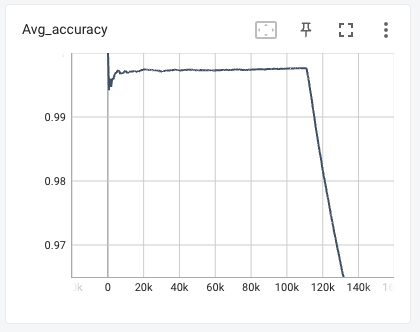

Finally, the users can also plot the custom metrics they defined, which in this case were the initial accuracy of the model and the most recent accuracy.

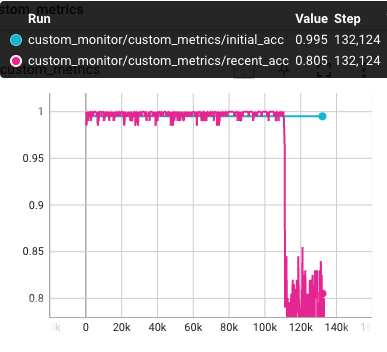